In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os

In [2]:
from IPython.display import Image, display
import matplotlib.cm as cm
from distutils.dir_util import copy_tree, remove_tree

In [3]:
from PIL import Image
from random import randint

In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"
if os.path.exists(work_dir):
    remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [8]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 100
IMAGE_SIZE = [IMG_SIZE, IMG_SIZE]
DIM = (IMG_SIZE, IMG_SIZE)

In [9]:
#Performing Image Augmentation to have more data samples
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=True)

Found 6400 images belonging to 4 classes.


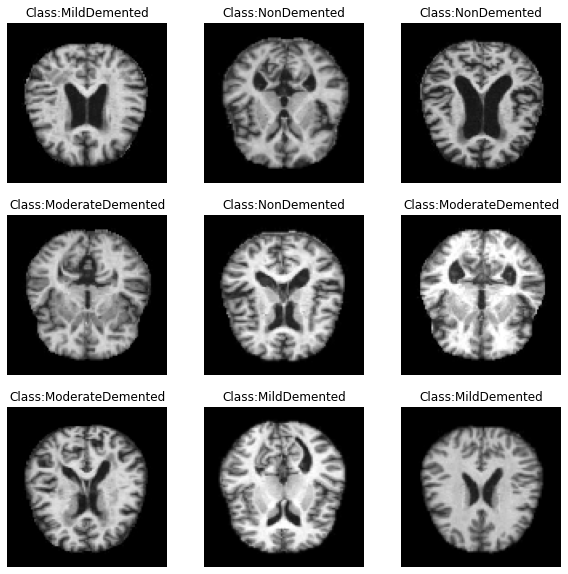

In [10]:
def show_images(generator,y_pred=None, nn=6400):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, nn)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen,nn=6400)

In [11]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

In [12]:
#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)

(6400, 100, 100, 3) (6400, 4)


In [13]:
#Splitting the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# OVERSAMPLING

In [14]:
# OVER SAMPLING
# - train data
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(8076, 100, 100, 3) (8076, 4)


In [15]:
# OVER SAMPLING
# - validation data
val_data, val_labels = sm.fit_resample(val_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), val_labels)
val_data = val_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(val_data.shape, val_labels.shape)

(2072, 100, 100, 3) (2072, 4)


In [16]:
# OVER SAMPLING
# - test data
test_data, test_labels = sm.fit_resample(test_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), test_labels)
test_data = test_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(test_data.shape, test_labels.shape)

(2652, 100, 100, 3) (2652, 4)


# CNN

In [17]:
def conv_block(filters, act='relu',i=0):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_p{i}'))
    block.add(Conv2D(filters, 3, activation=act, padding='same', name=f'conv2d_pp{i}'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [18]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [19]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),     
        MaxPool2D(), 
#         conv_block(32,i=1),
        Conv2D(32, 3, activation='relu', padding='same', name=f'conv2d_p1'),
        Conv2D(32, 3, activation='relu', padding='same', name=f'conv2d_pp1'),
        BatchNormalization(),
        MaxPool2D(),
        
#         conv_block(64,i=2),
        Conv2D(64, 3, activation='relu', padding='same', name=f'conv2d_p2'),
        Conv2D(64, 3, activation='relu', padding='same', name=f'conv2d_pp2'),
        BatchNormalization(),
        MaxPool2D(), 
        
#         conv_block(128,i=3),
        Conv2D(128, 3, activation='relu', padding='same', name=f'conv2d_p3'),
        Conv2D(128, 3, activation='relu', padding='same', name=f'conv2d_pp3'),
        BatchNormalization(),
        MaxPool2D(),
        
        Dropout(0.2),
#         conv_block(256,i=4),
        Conv2D(256, 3, activation='relu', padding='same', name=f'conv2d_p4'),
        Conv2D(256, 3, activation='relu', padding='same', name=f'conv2d_pp4'),
        BatchNormalization(),
        MaxPool2D(),
        
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [20]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [21]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]


model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_p1 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 conv2d_pp1 (Conv2D)         (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                           

In [22]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 20
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/20
253/253 [==============================] - 460s 2s/step - loss: 1.6990 - acc: 0.2760 - auc: 0.5296 - f1_score: 0.2750 - val_loss: 1.8505 - val_acc: 0.2500 - val_auc: 0.4703 - val_f1_score: 0.1000
Epoch 2/20
253/253 [==============================] - 408s 2s/step - loss: 1.1545 - acc: 0.4745 - auc: 0.7517 - f1_score: 0.4587 - val_loss: 2.5709 - val_acc: 0.2495 - val_auc: 0.4588 - val_f1_score: 0.1073
Epoch 3/20
253/253 [==============================] - 345s 1s/step - loss: 0.7919 - acc: 0.6253 - auc: 0.8825 - f1_score: 0.6133 - val_loss: 2.6874 - val_acc: 0.3398 - val_auc: 0.6168 - val_f1_score: 0.2308
Epoch 4/20
253/253 [==============================] - 318s 1s/step - loss: 0.7021 - acc: 0.6674 - auc: 0.9073 - f1_score: 0.6624 - val_loss: 6.9321 - val_acc: 0.2500 - val_auc: 0.5018 - val_f1_score: 0.1000
Epoch 5/20
253/253 [==============================] - 294s 1s/step - loss: 0.6414 - acc: 0.7077 - auc: 0.9237 - f1_score: 0.7041 - val_loss: 2.0750 - val_acc: 0.3668 - val_

# TRAINING AND TESTING THE MODEL

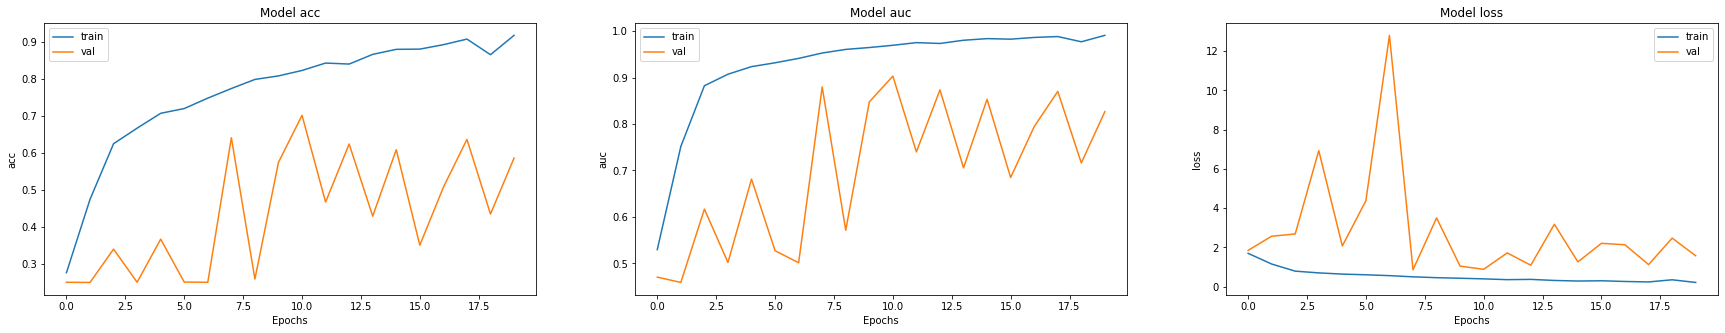

In [24]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()
for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [25]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

83/83 [==============================] - 29s 335ms/step - loss: 1.4291 - acc: 0.6222 - auc: 0.8541 - f1_score: 0.6032
Testing Accuracy: 62.22%


In [26]:
#Predicting the test data

pred_labels = model.predict(test_data)

83/83 [==============================] - 30s 346ms/step


In [28]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.94      0.20      0.33       663
VeryMildDemented       1.00      0.81      0.89       663
    MildDemented       0.62      0.93      0.75       663
ModerateDemented       0.37      0.56      0.45       663

       micro avg       0.62      0.62      0.62      2652
       macro avg       0.73      0.62      0.60      2652
    weighted avg       0.73      0.62      0.60      2652
     samples avg       0.62      0.62      0.62      2652



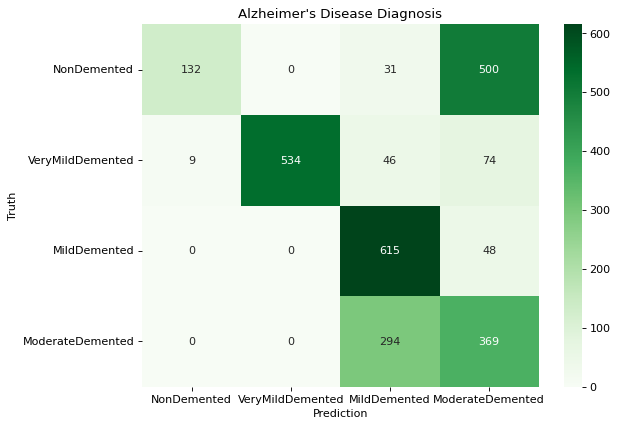

In [29]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [31]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 62.22 %
Matthew's Correlation Coefficient: 52.16 %


In [32]:
#Saving the model for future use

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [33]:
#pretrained_model = tf.keras.models.load_model(model_dir)

#Check its architecture
#plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
